**Table of contents**<a id='toc0_'></a>    
- 1. [Logistics](#toc1_)    
- 2. [Recap of Python](#toc2_)    
- 3. [Recap of probability and statistics](#toc4_)    
  - 3.1. [Law of large number (LLN)](#toc4_1_)    
  - 3.2. [Central limit theorem](#toc4_2_)    
  - 3.3. [Gaussian distributions](#toc4_3_)    
- 4. [Application: the longest path problem (V1)](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Logistics](#toc0_)

1. Discussions: Yifu (yifutang@berkeley.edu) and Jinghai (jinghai_he@berkeley.edu)

2. Contact: please use "[INDENG 231]" in the email title

3. AI tools usage is allowed, but you must exlicitly disclose all your usage at the beginning of your homework submission.

# 2. <a id='toc2_'></a>[Recap of Python](#toc0_)

* We will use Python for this course and we assume basic knowledge of Python. Specifically, all discussions and homework materials are Jupyter notebooks.

If you are new to Python, below are some recommended choices:

1. Anaconda/miniconda -> Jupyter notebook/Jupyter lab

2. VSCode -> Jupyter notebook

The first one is easier to set up, and the second one is better integrated with AI tools (Copilot).

In [ ]:
import numpy as np

# Given mean vector and covariance matrix
mean_vector = [0, 0]
cov_matrix = [[1, 0.5], [0.5, 1]]

# Generate multivariate normal data
normal_data = np.random.multivariate_normal(mean_vector, cov_matrix, 1000)

# Convert to lognormal data
lognormal_data = np.exp(normal_data)

print(lognormal_data)

[[0.58570964 1.33489643]
 [1.8454079  0.68737686]
 [1.02014605 0.84688994]
 ...
 [1.99096421 1.03900204]
 [0.93938711 0.36036815]
 [0.79658507 0.36682735]]


# 3. <a id='toc4_'></a>[Recap of probability and statistics](#toc0_)

## 3.1. <a id='toc4_1_'></a>[Law of large number (LLN)](#toc0_)

* Weak law: For i.i.d. random variables $X_i,i=1,\cdots,n$ with $\mathbb{E}\vert X\vert<+\infty$, $\frac{1}{n}\sum_{i=1}^nX_i$ converges to $p=\mathbb E X$ in probability.

    * For any $\varepsilon>0$, $$\lim_{n\to+\infty}P(\vert\frac{1}{n}\sum_{i=1}^nX_i-p\vert>\varepsilon)=0.$$

* Strong version

    * Almost sure convergence:  $$P(\lim_{n\to+\infty}\frac{1}{n}\sum_{i=1}^nX_i=p)=1.$$

This is the basic reason we can use simulations to appproximate the groundtruth.

The following is an example for Bernoulli distribution.

In [5]:
np.random.seed(2026)

def bernoulli_data(p, n):
    data = np.random.binomial(1, p, n)
    sample_mean = np.mean(data)
    return sample_mean


T = 10000
eps = 0.01
p = 0.3
n = 10000

sample_means = [bernoulli_data(p, n) for _ in range(T)]


In [8]:
sum([1 for x in sample_means if abs(x - p) < eps]) / T

0.9726

The condition $\mathbb{E}\vert X\vert<+\infty$ is necessary for LLN to hold:

* Cauchy distribution: heavy tailed; $\mathbb{E}\vert X\vert =+\infty$.

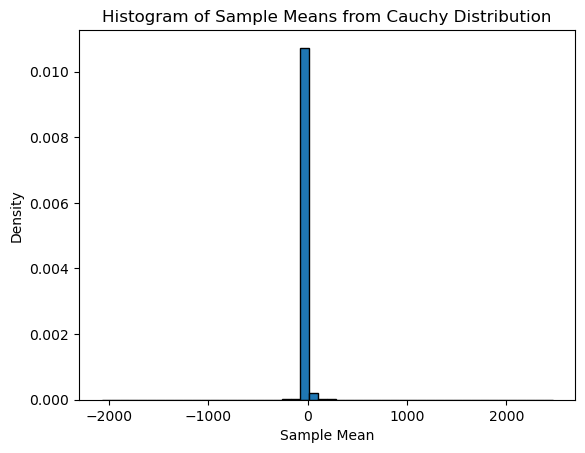

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def generate_cauchy_sample_mean(n):
    """
    Generate n samples from a Cauchy distribution and return the sample mean.
    
    Parameters:
    n (int): Number of samples to generate.
    
    Returns:
    float: The sample mean of the generated Cauchy samples.
    """
    samples = np.random.standard_cauchy(n)
    sample_mean = np.mean(samples)
    return sample_mean

def repeat_cauchy_experiment(T, n):
    """
    Repeat the Cauchy sample mean experiment T times and return the list of sample means.
    
    Parameters:
    T (int): Number of times to repeat the experiment.
    n (int): Number of samples to generate in each experiment.
    
    Returns:
    list: A list of sample means from each experiment.
    """
    sample_means = [generate_cauchy_sample_mean(n) for _ in range(T)]
    return sample_means

def plot_histogram(sample_means):
    """
    Plot a histogram of the sample means.
    
    Parameters:
    sample_means (list): A list of sample means to plot.
    """
    plt.hist(sample_means, bins=50, density=True, edgecolor='black')
    plt.title('Histogram of Sample Means from Cauchy Distribution')
    plt.xlabel('Sample Mean')
    plt.ylabel('Density')
    plt.show()

# Parameters
T = 10000  # Number of experiments
n = 10000   # Number of samples in each experiment

# Generate sample means
sample_means = repeat_cauchy_experiment(T, n)

# Plot the histogram
plot_histogram(sample_means)

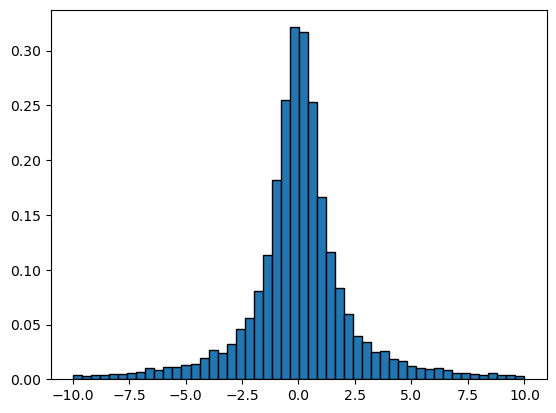

In [20]:
sample_means_filtered = [x for x in sample_means if -10 <= x <= 10]
plt.hist(sample_means_filtered, bins=50, density=True, edgecolor='black')
plt.show()

In [8]:
eps = 0.1
sum([1 for x in sample_means if abs(x) < eps]) / T

0.066

## 3.2. <a id='toc4_2_'></a>[Central limit theorem](#toc0_)

* We already know the sample mean somehow converges to the expectation (true mean) under mild conditions, but how fast is it?

    * Different scenarios should have different convergence rate. We need to know this to

        1. Evaluate our simulation results: what's the error of our approximation?

        2. Estimate number of replications needed: how many replications do I need to simulate?

* Luckily, for a wide class of problems, we have the following result:

For i.i.d. $X_i$, if $\mathbb{E} X^2<+\infty$ (or equivalently, $\operatorname{Var}(X)=\sigma^2<+\infty$), then $$\frac{\sqrt{n}\left({\sum_{i=1}^nX_i}/{n}-\mu\right)}{\sigma}\stackrel{d.}\to N(0,1).$$

* Finite variance is important.

* With CLT, we can evaluate our approximation as follows:

    1. Obtain $N$ replications;

    2. Estimate $\mu, \sigma$ with sample mean/sample standard deviation: $\hat{\mu}, \hat{\sigma}$.

    3. $\hat{\mu}-\mu\approx \frac{\hat\sigma}{\sqrt{n}}N(0,1).$

    4. A $95\%$ confidence interval (CI) for $\mu$: $\left[\hat{\mu}-1.96\frac{\hat\sigma}{\sqrt{n}}, \hat{\mu}+1.96\frac{\hat\sigma}{\sqrt{n}}\right]$.

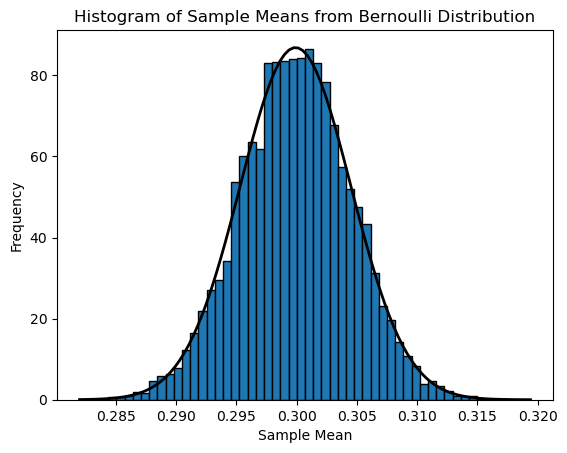

In [9]:
T = 10000
p = 0.3
n = 10000

sample_means = [bernoulli_data(p, n) for _ in range(T)]

plt.hist(sample_means, bins=50, density=True, edgecolor='black')
# fit a gaussian distribution to the data and plot it
from scipy.stats import norm
mu, std = norm.fit(sample_means)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Histogram of Sample Means from Bernoulli Distribution")
plt.xlabel("Sample Mean")
plt.ylabel("Frequency")
plt.show()

Extensions: 

1. Non-i.i.d. CLT: Lindeberg-Feller CLT, Lyapunov CLT

2. While CLT was validated by real data hundreds of years ago since Gauss, its proof is not as intuitive as its result. It took more than 100 years for mathematicians to derive the first rigorous proof. One simplest way to prove it is to use the characteristic function:

    * $\phi_X(t)=\mathbb{E}e^{itX}$, which maps a r.v. to a function $\mathbb{R}\to\mathbb{C}$.

    * Show that the characteristic function of $\frac{\sqrt{n}\left({\sum_{i=1}^nX_i}/{n}-\mu\right)}{\sigma}$ converges pointwisely to that of $N(0,1)$.

    * Inversion formula: the convergence of characteristic function sequence can be somehow translated to the convergence of r.v.

3. How fast the CLT converges?

    * In practice, usually $n>30$ is enough.

    * Slow when $X$ is heavy-tailed.

    * Can be further bounded by the skewness ($\mathbb{E}\vert X\vert^3$).

## 3.3. <a id='toc4_3_'></a>[Gaussian distributions](#toc0_)

* $X\in\mathbb{R}^d\sim N(\mu,\Sigma)$, where $\mu\in\mathbb{R}^d$ is the mean vector, and $\Sigma\in\mathbb{R}^{d\times d}$ is the covariance matrix.

# 4. <a id='toc5_'></a>[Application: the longest path problem (V1)](#toc0_)

Consider a graph with 4 nodes: 1, 2, 3, 4. Suppose we have 5 directed edges: 1->2, 1->3, 2->3, 2->4, 3->4, denoted by $e_1$ to $e_5$ (and also their lengths).

Now, suppose the joint distribution of $e\in\mathbb{R}^5$ follows a lognormal distribution $e\sim \operatorname{lognormal}(\mu,\Sigma)$.

Q: What's the expectation of the longest path from node 1 to 4?

In [10]:
mu_vec = np.array([1.5, 2.0, 1.0, 3.5, 3.0])
Sigma = 2.0*np.eye(5)+4.0*np.ones((5,5))
print(Sigma)

[[6. 4. 4. 4. 4.]
 [4. 6. 4. 4. 4.]
 [4. 4. 6. 4. 4.]
 [4. 4. 4. 6. 4.]
 [4. 4. 4. 4. 6.]]


* $L=\max\left(e_1+e_4, e_1+e_3+e_5,e_2+e_5\right)$

In [11]:
def simulate_calculate_longest_path(mu_vec, Sigma, T):
    paths = np.random.multivariate_normal(mu_vec, Sigma, T)
    results = np.vstack([paths[:, 0]+paths[:, 3], paths[:, 0]+paths[:, 2]+paths[:, 4], paths[:, 1]+paths[:, 4]]).T
    longest_paths = np.max(results, axis=1)
    indices = np.argmax(results, axis=1)
    return longest_paths, indices


In [12]:
n = 10000
longest_paths, indices = simulate_calculate_longest_path(mu_vec, Sigma, n)

6.985603720588634


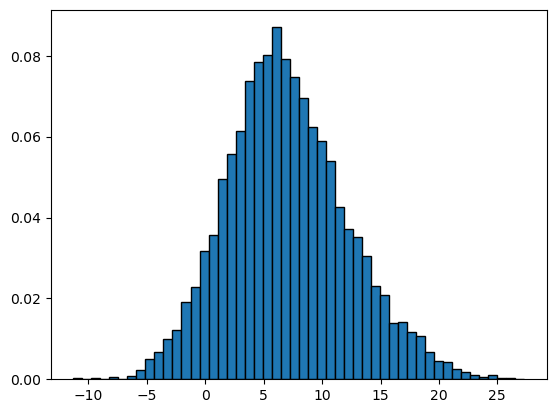

In [13]:
print(np.mean(longest_paths))
plt.hist(longest_paths, bins=50, density=True, edgecolor='black')
plt.show()

In [14]:
# CLT for confidence interval
lcb, ucb = np.mean(longest_paths) - 1.96*np.std(longest_paths)/np.sqrt(n), np.mean(longest_paths) + 1.96*np.std(longest_paths)/np.sqrt(n)
print(f'the 95% confidence interval is ({lcb}, {ucb})')

the 95% confidence interval is (6.8844282279387565, 7.086779213238512)


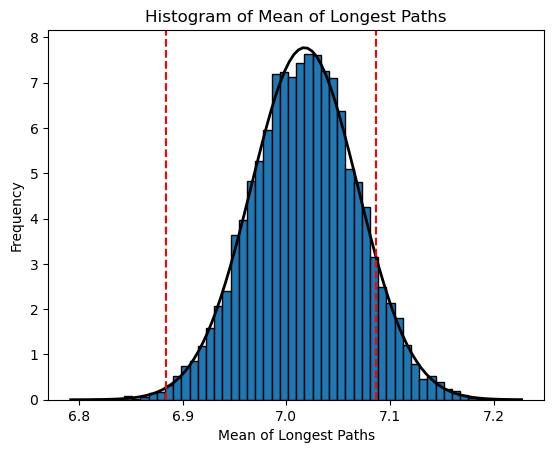

In [15]:
T = 10000
mean_list = [] 

for _ in range(T):
    longest_paths, _ = simulate_calculate_longest_path(mu_vec, Sigma, n)
    mean_list.append(np.mean(longest_paths))

plt.hist(mean_list, bins=50, density=True, edgecolor='black')
mu, std = norm.fit(mean_list)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Histogram of Mean of Longest Paths")
plt.xlabel("Mean of Longest Paths")
plt.ylabel("Frequency")
# add two vertical lines at the 95% confidence interval
plt.axvline(x=lcb, color='r', linestyle='--')
plt.axvline(x=ucb, color='r', linestyle='--')
plt.show()
